In [1]:
!pip install folium
import folium
import pandas as pd
import requests  
import numpy as np
from pandas.io.json import json_normalize 
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')
!pip install kmeans
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt 

# THE BEST LOCATION FOR A CRAFT BEER BAR IN PARIS

## Using data science to find the best location

# Introduction:

## Background

The craft beer movement, a trend imported from the United States, is spreading all around Europe and is growing steadily in France, originally considered as a wine country. The insatiable demand for quality craft beer led to the creation of more and more microbreweries and beer bars specialized in craft beer over the past 15 years.

## Goals

Through data science, the following analysis tries to define the most favorable districts to establish a craft beer bar in Paris, France. Using data analysis, data visualization and machine learning, we will narrow down neighborhoods in Paris based on different criteria:

First, we want our bar to be located in an attractive and vibrant area of Paris, with an active nightlife. The presence of other nearby venues will attract people and create traffic. On the other hand, as our concept represents a niche (craft beer lovers), we want to avoid the presence of direct competitors in the same neighborhood. At last, Paris is a very expensive city and the exorbitant real estate prices can be a barrier to entry for opening a business. Thus, we will focus on neighborhoods whose prices match our budget.

This analysis represents a draft market study for a business plan or an executive summary. It is intended for potential entrepreneurs who want to better understand the market of craft beer pubs in Paris by providing a data-driven insight into the best locations, based on specific criteria.


# Data:

Paris is divided in 20 boroughs called “Arrondissements” and 80 neighborhoods. Data about boroughs and neighborhoods is available online. Names and geographical coordinates for each neighborhood can be found here: https://www.data.gouv.fr/fr/datasets/quartiers-administratifs/. 
The average price per Square Meter is provided by DataFrance : https://datafrance.info/paris-75000.

To compare neighborhoods among each other’s, we will use the Foursquare API that list all venues in specific areas. We will then be able to cluster the neighborhoods based on their similarities using unsupervised machine learning technique to select the best fit for our craft beer pub.


## I. Collecting the data

The data used is collected from two sources : https://datafrance.info/paris-75000 and https://www.data.gouv.fr/fr/datasets/quartiers-administratifs/ as JSON files.

After cleaning, the master data looks like this: 

In [2]:
df=pd.read_csv('Paris_data.csv')
df

,Neighborhood,Arrondissement,Latitude,Longitude,Price
0,Place-Vendome,1,48.867019,2.328582,9816
1,Halles,1,48.862289,2.344899,9816
2,Palais-Royal,1,48.864660,2.336309,9816
3,Saint-Germain-l'Auxerrois,1,48.860650,2.334910,9816
4,Gaillon,2,48.869307,2.333432,11262
...,...,...,...,...,...
75,Amerique,19,48.881638,2.395440,7909
76,Charonne,20,48.854760,2.407430,7853
77,Saint-Fargeau,20,48.871035,2.406172,7853
78,Belleville,20,48.871531,2.387549,7853


It contains the necessary of information : Neighborhood, Borough, Latitude, Longitude and average square meter price.

Note that the table shows 80 rows representing the 80 neighborhoods. 

# II. Segmenting the data

## A- Creating a map of Paris and its neighborhoods

I used the geographical data of each neighborhood to visualize them on the map with the Folium library in Python.

In [3]:
map_paris = folium.Map(location=[48.85889, 2.32004], zoom_start=12)

# add markers to map
for lat, lng, neighborhood in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_paris)  
    
map_paris

## B- Using Foursquare API to get the venues:

We want our bar to be located in a good area with an active night life and similar venues around to attract customers. 

To explore and define the type of neighborhood, I use the Foursquare API to get all nearby venues around. I set the limit to 500 in a radius of 1km.

In [4]:
# My Foursquare credentials
CLIENT_ID = 'EA24PWBDYH1ZZQBWDRQEOGZVDDUEAYKHZ3OOTVGFP3CLRJ0T'
CLIENT_SECRET = 'FROZNBYP2JUVWRWEB2B0RLIL4UDMX30TEJWL25PBF421VTYC' 
VERSION = '20211005'
ACCESS_TOKEN = 'Z3G1ZAJAUNVEMK3R4VA41YMC5NCQZABT5TO1HZU2ZEOVP35R'

In [5]:
neighborhood_latitude = df.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df.loc[0, 'Longitude'] # neighborhood longitude value
neighborhood_name = df.loc[0, 'Neighborhood'] # neighborhood name

In [6]:
LIMIT=500
radius=1000
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=EA24PWBDYH1ZZQBWDRQEOGZVDDUEAYKHZ3OOTVGFP3CLRJ0T&client_secret=FROZNBYP2JUVWRWEB2B0RLIL4UDMX30TEJWL25PBF421VTYC&v=20211005&ll=48.8670185906,2.32858166493&radius=1000&limit=500'

In [7]:
 def getNearbyVenues(names, latitudes, longitudes, radius=500):

    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',]
    
    return(nearby_venues)

paris_venues = getNearbyVenues(names=df['Neighborhood'],latitudes=df['Latitude'],longitudes=df['Longitude'])
print(paris_venues.shape)

Place-Vendome
Halles
Palais-Royal
Saint-Germain-l'Auxerrois
Gaillon
Mail
Bonne-Nouvelle
Vivienne
Archives
Sainte-Avoie
Arts-et-Metiers
Enfants-Rouges
Saint-Merri
Saint-Gervais
Arsenal
Notre-Dame
Jardin-des-Plantes
Val-de-Grace
Sorbonne
Saint-Victor
Saint-Germain-des-Pres
Odeon
Notre-Dame-des-Champs
Monnaie
Invalides
Ecole-Militaire
Gros-Caillou
Saint-Thomas-d'Aquin
Champs-Elysees
Europe
Faubourg-du-Roule
Madeleine
Saint-Georges
Faubourg-Montmartre
Chaussee-d'Antin
Rochechouart
Hopital-Saint-Louis
Porte-Saint-Denis
Saint-Vincent-de-Paul
Porte-Saint-Martin
Folie-Mericourt
Sainte-Marguerite
Saint-Ambroise
Roquette
Bel-Air
Picpus
Bercy
Quinze-Vingts
Salpetriere
Croulebarbe
Maison-Blanche
Gare
Parc-de-Montsouris
Plaisance
Petit-Montrouge
Montparnasse
Necker
Grenelle
Javel
Saint-Lambert
Muette
Porte-Dauphine
Auteuil
Chaillot
Epinettes
Plaine de Monceaux
Ternes
Batignolles
Grandes-Carrieres
La Chapelle
Goutte-d'Or
Clignancourt
Combat
Villette
Pont-de-Flandre
Amerique
Charonne
Saint-Fargeau
Be

Here is a head of the list with the venues name, category, latitude and longitude information from Forsquare API.

In [8]:
paris_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Place-Vendome,48.867019,2.328582,Hôtel Ritz,48.868106,2.328892,Hotel
1,Place-Vendome,48.867019,2.328582,Place Vendôme,48.867798,2.329741,Plaza
2,Place-Vendome,48.867019,2.328582,Hôtel Mandarin Oriental,48.866987,2.327178,Hotel
3,Place-Vendome,48.867019,2.328582,Charvet,48.868312,2.330282,Men's Store
4,Place-Vendome,48.867019,2.328582,Ladurée,48.866121,2.328449,Dessert Shop


In [9]:
print('There are {} uniques venues categories.'.format(len(paris_venues['Venue Category'].unique())))

There are 300 uniques venues categories.


I put all the venues into a data frame. We notice that the table has 5036 rows which means that the Foursquare request found 5036 nearby venues with 297 unique venues categories.

### Let's check how many venues are returned for each neighborhood to see the most active ones

In [10]:
venue_count = paris_venues.groupby('Neighborhood').count().reset_index()
venue_count['Count'] = venue_count['Venue']
venue_count = venue_count.drop(['Neighborhood Latitude', 'Neighborhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude','Venue Category'], axis=1)
venue_count = venue_count.sort_values('Count').reset_index(drop=True)
venue_count

,Neighborhood,Count
0,Picpus,2
1,Bel-Air,6
2,Muette,8
3,Saint-Fargeau,12
4,Porte-Dauphine,12
...,...,...
75,Folie-Mericourt,100
76,Saint-Germain-des-Pres,100
77,Gaillon,100
78,Hopital-Saint-Louis,100


We can visualize them using a bar chart

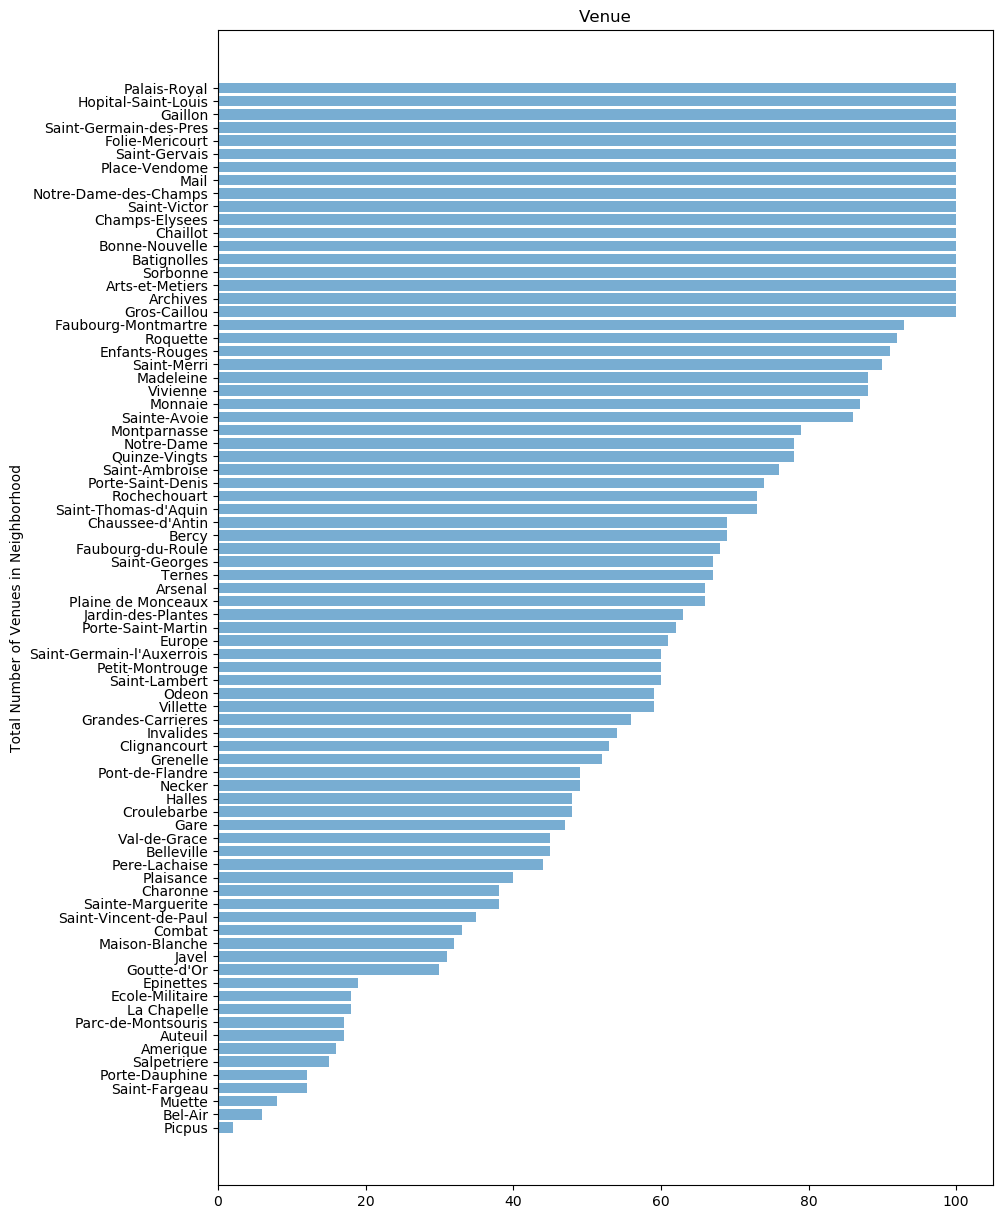

In [11]:
plt.rcdefaults()
objects = venue_count.Neighborhood
y_pos = np.arange(len(objects))
performance = venue_count.Count
plt.figure(figsize=(10,15))
plt.barh(y_pos, performance, align='center', alpha=0.6)
plt.yticks(y_pos, objects)
plt.ylabel('Total Number of Venues in Neighborhood')
plt.title('Venue')

plt.show()

## C- Creating a new dataframe with the top 10 venues for each neighborhood

In [12]:
paris_onehot = pd.get_dummies(paris_venues[['Venue Category']], prefix="", prefix_sep="")
paris_onehot['Neighborhood'] = paris_venues['Neighborhood'] 
fixed_columns = [paris_onehot.columns[-1]] + list(paris_onehot.columns[:-1])
paris_onehot = paris_onehot[fixed_columns]
paris_grouped = paris_onehot.groupby('Neighborhood').mean().reset_index()

In [13]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = paris_grouped['Neighborhood']

for ind in np.arange(paris_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(paris_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Amerique,French Restaurant,Supermarket,Bus Stop,Pool,Bike Rental / Bike Share,Bistro,Martial Arts School,Park,Plaza,Street Art
1,Archives,French Restaurant,Hotel,Coffee Shop,Bar,Japanese Restaurant,Clothing Store,Art Gallery,Italian Restaurant,Historic Site,Plaza
2,Arsenal,French Restaurant,Hotel,Plaza,Park,Italian Restaurant,Boat or Ferry,Gastropub,Tapas Restaurant,Pedestrian Plaza,Vegetarian / Vegan Restaurant
3,Arts-et-Metiers,French Restaurant,Hotel,Cocktail Bar,Wine Bar,Italian Restaurant,Chinese Restaurant,Coffee Shop,Japanese Restaurant,Vietnamese Restaurant,Restaurant
4,Auteuil,Tennis Court,Stadium,Garden,Office,Outdoors & Recreation,Botanical Garden,Plaza,French Restaurant,Museum,Sporting Goods Shop


In this table, we discover the 10 most common venues for each neighborhood. This already gives us some insight about the type of neighborhood and if it can be a good fit for a craft beer bar. 

# III. Clustering similar neighborhoods using K-means

Now that we know some characteristics of Parisian neighborhoods, we can create clusters based on their similarities using an unsupervised machine learning tool called K-means. 

## A- Defining the best number of clusters 

To define the most appropriate number of clusters, I use the silhouette score. 

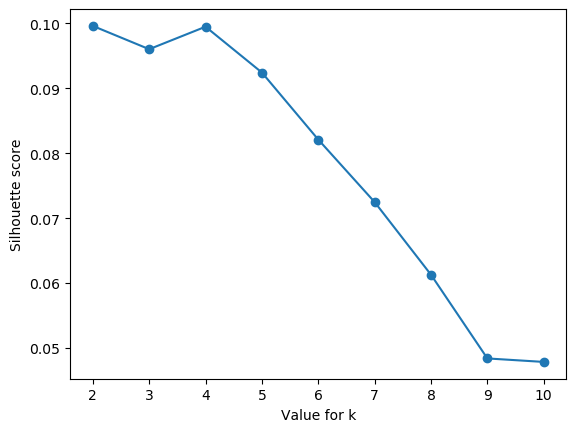

[0.09958791373825017,
 0.09600434908943677,
 0.09946686911345308,
 0.09241176878230598,
 0.08209162157469703,
 0.07247185301420436,
 0.06128864317108127,
 0.04840608839317371,
 0.04786958270222876]

In [14]:
paris_cluster = paris_grouped.drop('Neighborhood', 1)

k = [2, 3, 4, 5, 6, 7, 8, 9, 10]

sil=[]

for n_cluster in k:
    kmeans = KMeans(n_clusters=n_cluster).fit(paris_cluster)
    silhouette_avg = silhouette_score(paris_cluster, kmeans.labels_)
    sil.append(silhouette_score(paris_cluster, kmeans.labels_))

plt.plot(k, sil, 'o-')
plt.xlabel("Value for k")
plt.ylabel("Silhouette score")
plt.show()
sil

The best number of clusters is 6.

## B. Clustering the neighborhoods in Paris

K-Means will assign each neighborhood to a cluster. I added the cluster label in a new column of the dataframe. 

In [15]:
kclusters = 6
paris_grouped_clustering = paris_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(paris_grouped_clustering)
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

paris_merged = df
paris_merged = paris_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
paris_merged=paris_merged.astype({"Cluster Labels": int})
paris_merged.head()

,Neighborhood,Arrondissement,Latitude,Longitude,Price,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Place-Vendome,1,48.867019,2.328582,9816,2,Hotel,French Restaurant,Jewelry Store,Chocolate Shop,Boutique,Japanese Restaurant,Bookstore,Hotel Bar,Plaza,Accessories Store
1,Halles,1,48.862289,2.344899,9816,4,French Restaurant,Bakery,Coffee Shop,Ice Cream Shop,Spa,Tea Room,Art Gallery,Chinese Restaurant,Sandwich Place,Plaza
2,Palais-Royal,1,48.864660,2.336309,9816,4,Japanese Restaurant,French Restaurant,Hotel,Plaza,Italian Restaurant,Café,Historic Site,Wine Bar,Bookstore,Bakery
3,Saint-Germain-l'Auxerrois,1,48.860650,2.334910,9816,2,French Restaurant,Hotel,Plaza,Historic Site,Art Museum,Cosmetics Shop,Italian Restaurant,Coffee Shop,Theater,Tea Room
4,Gaillon,2,48.869307,2.333432,11262,4,Japanese Restaurant,Hotel,French Restaurant,Italian Restaurant,Wine Bar,Theater,Jewelry Store,Coffee Shop,Korean Restaurant,Gourmet Shop


Now it's time to visualize the 6 different clusters on the map, using Folium.

In [16]:
# create map
map_clusters = folium.Map(location=[48.8534, 2.3488], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(paris_merged['Latitude'], paris_merged['Longitude'], paris_merged['Neighborhood'], paris_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Neighborhoods are grouped into 6 clusters based on their characteristics. 

To open our beer bar, we are looking for an active location, where people go out. So let's analyze each clusters :

### Cluster 0 (red) : Mostly restaurants. 

In [17]:
paris_merged.loc[paris_merged['Cluster Labels'] == 0, paris_merged.columns[[0] + list(range(5, paris_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
75,Amerique,0,French Restaurant,Supermarket,Bus Stop,Pool,Bike Rental / Bike Share,Bistro,Martial Arts School,Park,Plaza,Street Art
77,Saint-Fargeau,0,Supermarket,Food Truck,Bistro,French Restaurant,Laundromat,Diner,Pool,Pizza Place,Plaza,Café


###  Cluster 1 (purple): Mostly hotels.

In [18]:
paris_merged.loc[paris_merged['Cluster Labels'] == 1, paris_merged.columns[[0] + list(range(5, paris_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
44,Bel-Air,1,Recreation Center,French Restaurant,Café,Playground,Plaza,Sports Club,Office,Okonomiyaki Restaurant,Opera House,Optical Shop


###  Cluster 2 (blue): not an interesting place for a bar.

In [19]:
paris_merged.loc[paris_merged['Cluster Labels'] == 2, paris_merged.columns[[0] + list(range(5, paris_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Place-Vendome,2,Hotel,French Restaurant,Jewelry Store,Chocolate Shop,Boutique,Japanese Restaurant,Bookstore,Hotel Bar,Plaza,Accessories Store
3,Saint-Germain-l'Auxerrois,2,French Restaurant,Hotel,Plaza,Historic Site,Art Museum,Cosmetics Shop,Italian Restaurant,Coffee Shop,Theater,Tea Room
20,Saint-Germain-des-Pres,2,French Restaurant,Hotel,Italian Restaurant,Wine Bar,Plaza,Boutique,Pastry Shop,Café,Sandwich Place,Japanese Restaurant
25,Ecole-Militaire,2,Hotel,French Restaurant,Plaza,Garden,Bistro,Farmers Market,Dessert Shop,Diner,Café,Pastry Shop
28,Champs-Elysees,2,French Restaurant,Hotel,Boutique,Italian Restaurant,Clothing Store,Japanese Restaurant,Art Gallery,Garden,Plaza,Spa
30,Faubourg-du-Roule,2,Hotel,French Restaurant,Jewelry Store,Italian Restaurant,Asian Restaurant,Clothing Store,Cosmetics Shop,Japanese Restaurant,Men's Store,Electronics Store
31,Madeleine,2,Hotel,French Restaurant,Boutique,Women's Store,Gourmet Shop,Theater,Dessert Shop,Corsican Restaurant,Hotel Bar,Clothing Store
32,Saint-Georges,2,Hotel,French Restaurant,Italian Restaurant,Café,Lounge,Cocktail Bar,Bistro,Bakery,Japanese Restaurant,Beer Bar
34,Chaussee-d'Antin,2,Hotel,French Restaurant,Salad Place,Bistro,Coffee Shop,Jewelry Store,Chinese Restaurant,Theater,Concert Hall,Vietnamese Restaurant
53,Plaisance,2,Hotel,French Restaurant,Bistro,Bar,Grocery Store,Japanese Restaurant,Sushi Restaurant,Bakery,Café,Beer Store


###  Cluster 3 (turquoise): not an interesting place for a bar.

In [20]:
paris_merged.loc[paris_merged['Cluster Labels'] == 3, paris_merged.columns[[0] + list(range(5, paris_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
45,Picpus,3,Locksmith,Hotel,Accessories Store,Pet Store,Peruvian Restaurant,Perfume Shop,Performing Arts Venue,Pedestrian Plaza,Pastry Shop,Park


###  Cluster 4 (green): not an interesting place for a bar.

In [21]:
paris_merged.loc[paris_merged['Cluster Labels'] == 4, paris_merged.columns[[0] + list(range(5, paris_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Halles,4,French Restaurant,Bakery,Coffee Shop,Ice Cream Shop,Spa,Tea Room,Art Gallery,Chinese Restaurant,Sandwich Place,Plaza
2,Palais-Royal,4,Japanese Restaurant,French Restaurant,Hotel,Plaza,Italian Restaurant,Café,Historic Site,Wine Bar,Bookstore,Bakery
4,Gaillon,4,Japanese Restaurant,Hotel,French Restaurant,Italian Restaurant,Wine Bar,Theater,Jewelry Store,Coffee Shop,Korean Restaurant,Gourmet Shop
5,Mail,4,Cocktail Bar,French Restaurant,Wine Bar,Bakery,Bar,Hotel,Salad Place,Indie Movie Theater,Thai Restaurant,Bistro
6,Bonne-Nouvelle,4,Cocktail Bar,French Restaurant,Wine Bar,Bakery,Hotel,Bar,Italian Restaurant,Japanese Restaurant,Restaurant,Chinese Restaurant
7,Vivienne,4,French Restaurant,Japanese Restaurant,Hotel,Wine Bar,Coffee Shop,Salad Place,Bookstore,Bakery,Udon Restaurant,Clothing Store
8,Archives,4,French Restaurant,Hotel,Coffee Shop,Bar,Japanese Restaurant,Clothing Store,Art Gallery,Italian Restaurant,Historic Site,Plaza
9,Sainte-Avoie,4,French Restaurant,Art Gallery,Café,Hotel,Restaurant,Chinese Restaurant,Bakery,Vegetarian / Vegan Restaurant,Burger Joint,Japanese Restaurant
10,Arts-et-Metiers,4,French Restaurant,Hotel,Cocktail Bar,Wine Bar,Italian Restaurant,Chinese Restaurant,Coffee Shop,Japanese Restaurant,Vietnamese Restaurant,Restaurant
11,Enfants-Rouges,4,Hotel,French Restaurant,Japanese Restaurant,Wine Bar,Cocktail Bar,Sandwich Place,Bar,Art Gallery,Vietnamese Restaurant,Bakery


###  Cluster 5 (orange): a lot of bars, restaurants and cafés.

In [22]:
paris_merged.loc[paris_merged['Cluster Labels'] == 5, paris_merged.columns[[0] + list(range(5, paris_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,Arsenal,5,French Restaurant,Hotel,Plaza,Park,Italian Restaurant,Boat or Ferry,Gastropub,Tapas Restaurant,Pedestrian Plaza,Vegetarian / Vegan Restaurant
19,Saint-Victor,5,French Restaurant,Bakery,Hotel,Bar,Pub,Park,Bistro,Wine Bar,Japanese Restaurant,Italian Restaurant
22,Notre-Dame-des-Champs,5,French Restaurant,Hotel,Bakery,Japanese Restaurant,Italian Restaurant,Bistro,Steakhouse,Creperie,Ice Cream Shop,Theater
24,Invalides,5,French Restaurant,Hotel,Plaza,Bistro,History Museum,Café,Italian Restaurant,Art Museum,Restaurant,Park
26,Gros-Caillou,5,French Restaurant,Italian Restaurant,Hotel,Café,Ice Cream Shop,Bakery,Bistro,Coffee Shop,Dessert Shop,Cheese Shop
27,Saint-Thomas-d'Aquin,5,French Restaurant,Hotel,Café,Bakery,Coffee Shop,Art Gallery,Italian Restaurant,Cheese Shop,Tailor Shop,Shoe Store
29,Europe,5,French Restaurant,Hotel,Pizza Place,Bistro,Wine Shop,Sandwich Place,Thai Restaurant,Cosmetics Shop,Ice Cream Shop,Men's Store
33,Faubourg-Montmartre,5,French Restaurant,Hotel,Italian Restaurant,Vegetarian / Vegan Restaurant,Chinese Restaurant,Cocktail Bar,Restaurant,Thai Restaurant,Bakery,Gym / Fitness Center
35,Rochechouart,5,French Restaurant,Hotel,Bakery,Vegetarian / Vegan Restaurant,Pizza Place,Wine Bar,Park,Restaurant,Coffee Shop,Italian Restaurant
41,Sainte-Marguerite,5,French Restaurant,Bar,Italian Restaurant,Hotel,Bistro,Café,Beer Store,Thai Restaurant,Brasserie,Gym / Fitness Center


After analyzing each cluster, we want our bar to be in a neighborhood belonging to the cluster 0, 1 or 5. Those are the neighborhoods where we find numerous restaurants, bars, hotels, and cafés. 

In [34]:
# We narrow down neighborhoods from cluster 0, 1, 5.  
c1=paris_merged.loc[paris_merged['Cluster Labels'] == 0]
c2=paris_merged.loc[paris_merged['Cluster Labels'] == 1]
c3=paris_merged.loc[paris_merged['Cluster Labels'] == 5]
c1c2=c1.append(c2, ignore_index=True)
good_clusters=c1c2.append(c3,ignore_index=True)
good_clusters
good_clusters.shape

(22, 16)

# IV. Selecting Neighborhoods based on their average square meter price

Now that we narrowed down neighborhoods based on the nearby venues, it is important to look at the average square meter price for each neighborhood. Some neighborhoods in Paris are extremely expensive. Let us get rid of locations where the average price is above 9,8k€ per m2 so it can match our budget. We end up with 30 rows. 

In [35]:
good_price=good_clusters.loc[(good_clusters['Price'] < 9800)]
good_price.tail()

,Neighborhood,Arrondissement,Latitude,Longitude,Price,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,Necker,15,48.842711,2.310777,9583,5,French Restaurant,Hotel,Café,Dessert Shop,Gym / Fitness Center,Bakery,Restaurant,Pet Café,Supermarket,Chinese Restaurant
14,Javel,15,48.839060,2.278076,9583,5,French Restaurant,Pizza Place,Café,Sushi Restaurant,Bakery,Thrift / Vintage Store,Spanish Restaurant,Supermarket,Moroccan Restaurant,Park
15,Saint-Lambert,15,48.834294,2.296920,9583,5,French Restaurant,Hotel,Bakery,Plaza,Thai Restaurant,Italian Restaurant,Café,Supermarket,Burger Joint,Bookstore
20,Grandes-Carrieres,18,48.892578,2.334363,8874,5,French Restaurant,Hotel,Bar,Restaurant,Pizza Place,Park,Thai Restaurant,Bistro,Italian Restaurant,Track Stadium
21,Combat,19,48.878639,2.380127,7909,5,French Restaurant,Italian Restaurant,Park,Restaurant,Pool,Coffee Shop,Scenic Lookout,Bar,Beer Garden,Soup Place


# V. Dropping neighborhoods with competitors

To avoid competing with another already established craft beer pub, we need to check which selected neighborhoods already have a Beer bar. 


In [36]:
good_onehot=paris_onehot.loc[paris_onehot['Neighborhood'].isin(good_price['Neighborhood'])]
paris_beer = good_onehot[['Neighborhood','Beer Bar']]

paris_beer = paris_beer.groupby(['Neighborhood']).sum()

paris_beer = paris_beer.reset_index()
paris_beer = paris_beer.sort_values(by=['Beer Bar'],ascending=False)

paris_beer

,Neighborhood,Beer Bar
3,Grandes-Carrieres,1
8,Sainte-Marguerite,1
0,Amerique,0
1,Bel-Air,0
2,Combat,0
4,Javel,0
5,Necker,0
6,Saint-Fargeau,0
7,Saint-Lambert,0


'0' means there is no competitor for our craft beer project in this neighborhood. '1' means there is at least a beer bar already in place. We get rid of those neighborhoods.

# VI. Results and discussion

We then narrow down neighborhoods with no beer bar already present. 

At this stage, we can show a list of areas in Paris that have an active night life, within our budget range, with no direct competitor for our craft beer pub. Let's merge those variables with our master data table. 

In [37]:
indexNames = paris_beer[ paris_beer['Beer Bar'] == 1 ].index
paris_beer.drop(indexNames , inplace=True)

In [38]:
best_places=df.loc[df['Neighborhood'].isin(paris_beer['Neighborhood'])]
best_places.drop(['Price'], axis=1)

,Neighborhood,Arrondissement,Latitude,Longitude
44,Bel-Air,12,48.837996,2.433178
56,Necker,15,48.842711,2.310777
58,Javel,15,48.839060,2.278076
59,Saint-Lambert,15,48.834294,2.296920
72,Combat,19,48.878639,2.380127
75,Amerique,19,48.881638,2.395440
77,Saint-Fargeau,20,48.871035,2.406172


In [39]:
best_places.shape

(7, 5)

### Let's visualize them on the map

In [40]:
map_paris2 = folium.Map(location=[48.85889, 2.32004], zoom_start=12)

# add markers to map
for lat, lng, neighborhood in zip(best_places['Latitude'], best_places['Longitude'], best_places['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=13,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.4,
        parse_html=False).add_to(map_paris2)  
    
map_paris2

This last map shows the best location for opening a craft beer pub in Paris based on our criteria. 

After sorting out neighborhoods based on their average price and the competition already established, we notice that the best places are mostly located outside of the city's hyper center. The result is still quite large. 21 neighborhoods are shown on the map in 9 different boroughs. We could be more precise by adding other criteria depending on the project, such as the population in each district and the average standard of living of the inhabitants. Nonetheless, this analysis provides an overall view of the trends in each neighborhood. This study represents a first step to understand the best location for a beer pub in Paris but does not answer all the questions: how far is the location from my supplier? are there any premises available in the area?  And what about accessibility?

# VII.  Conclusion

Paris is a large and heterogeneous city. To determine the best place to open a beer bar, we need to know the characteristics of each district. To do so we can visualize them on a map using their geographical coordinates. The Foursquare API can obtain the venues nearby and draw up a portrait of each neighborhood based on the assigned venues. The use of K-Means classifies the neighborhoods into different clusters based on their similarities and thus allows us to visualize the neighborhoods by categories. In this case study, the neighborhoods selected are characterized by the presence of bars and restaurants nearby - attesting of the attractiveness of the area - its average price and preexistence of competitors. Several other criteria can be used to define the best location for a business. None of that would have been possible without data. The use of data enables entrepreneurs to find out useful hidden information that help them make more informed decision. A lot of data and tools are accessible and can grant an edge for smarter decision making. No surprise data analysis is becoming increasingly important to companies.